### Libraries, functions etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit
from scipy.io import arff

import sys
sys.path.insert(1, '../')

import measures
from model import LogReg
from preprocessing import Preprocessor
import experiments

### Loading data

In [3]:
data = arff.loadarff('../data/messidor_features.arff')
retinopathy_df = pd.DataFrame(data[0])

X_retinopathy=retinopathy_df.drop(columns='Class')
y_retinopathy=(retinopathy_df['Class'] == b'1').astype(int)

prep_ret = Preprocessor()

Basic data info:

In [8]:
X_retinopathy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1151 non-null   float64
 1   1       1151 non-null   float64
 2   2       1151 non-null   float64
 3   3       1151 non-null   float64
 4   4       1151 non-null   float64
 5   5       1151 non-null   float64
 6   6       1151 non-null   float64
 7   7       1151 non-null   float64
 8   8       1151 non-null   float64
 9   9       1151 non-null   float64
 10  10      1151 non-null   float64
 11  11      1151 non-null   float64
 12  12      1151 non-null   float64
 13  13      1151 non-null   float64
 14  14      1151 non-null   float64
 15  15      1151 non-null   float64
 16  16      1151 non-null   float64
 17  17      1151 non-null   float64
 18  18      1151 non-null   float64
dtypes: float64(19)
memory usage: 171.0 KB


Only numerical features, without missing values.

In [9]:
y_retinopathy.mean()

0.5308427454387489

The classes are balanced.

In [4]:
X_ret_train, X_ret_test, y_ret_train, y_ret_test = prep_ret.train_test_split(X_retinopathy, y_retinopathy)

In the task requierements we're asked to remove collinear variables, so we're left with only first 4 options. The GD and SGD results for these 4 are very similar (close to 63%). Thats why I would suggest taking the one where the remaining 2 achieve the best results (which in this case is no scaling and no target balancing). The remaining tests will be perfomed in this particular situation.

In [10]:
X_train=X_ret_train.copy()
X_test=X_ret_test.copy()
y_train=y_ret_train.copy()
y_test=y_ret_test.copy()

X_train = prep_ret.remove_multicollinearity_fit_transform(X_train)
X_test = prep_ret.remove_multicollinearity_transform(X_test)

X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
X_test=X_test.to_numpy()
y_test=y_test.to_numpy()

9 numerical features left in dataset  0  categorical


#### 1. Convergence analysis: check how the value of log-likelihood function depends on the number of iterations for 4 above algorithms.

In [92]:
lr=0.01
n_epochs=1000

lr_models = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=0.1),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=lr, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

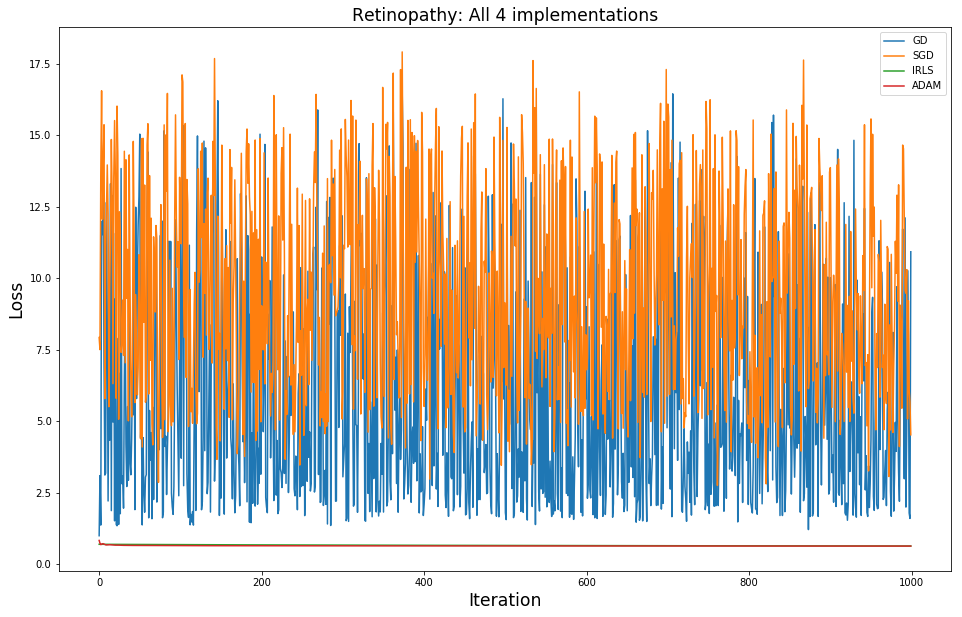

In [93]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train, y_train)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('Retinopathy: All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('retinopathy_conv_01.svg')
plt.show()

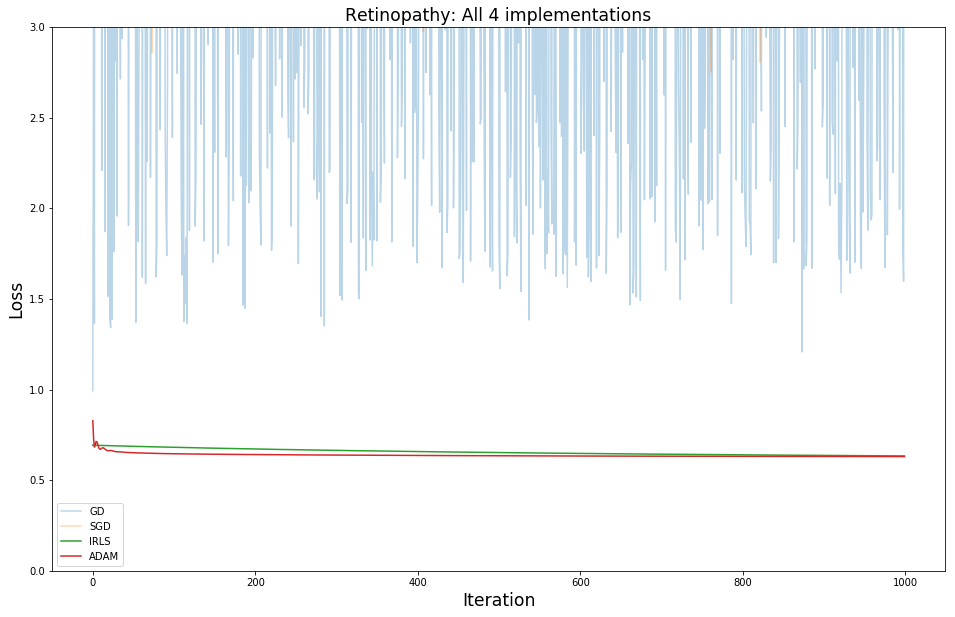

In [32]:
plt.figure(figsize=(16, 10))
for model_name, model in lr_models.items():
    a = 0.3 if 'GD' in model_name else 1.0
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name, alpha=a)
plt.title('Retinopathy: All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.ylim((0, 3))
plt.savefig('retinopathy_conv_02.svg')
plt.show()

In [20]:
acc, rec, prec, f_m = measures.get_measures(lr_models['ADAM'].predict(X_test), y_test)
print('Metrics of ADAM model on test subset')
print('Accuracy', round(acc, 2))
print('Recall', round(rec, 2))
print('Precision', round(prec, 2))
print('F1 score', round(f_m, 2))

Metrics of ADAM model on test subset
Accuracy 0.59
Recall 0.56
Precision 0.62
F1 score 0.59


### (1b) Checking the impact of scaling data before training

In [49]:
X_train_scaled=X_ret_train.copy()
X_test_scaled=X_ret_test.copy()
y_train_scaled=y_ret_train.copy()
y_test_scaled=y_ret_test.copy()


s = StandardScaler()
X_train_scaled = s.fit_transform(X_train_scaled)
X_test_scaled = s.transform(X_test_scaled)

y_train_scaled=y_train_scaled.to_numpy()
y_test_scaled=y_test_scaled.to_numpy()

In [50]:
lr_models_scaled = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=0.1),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=lr, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

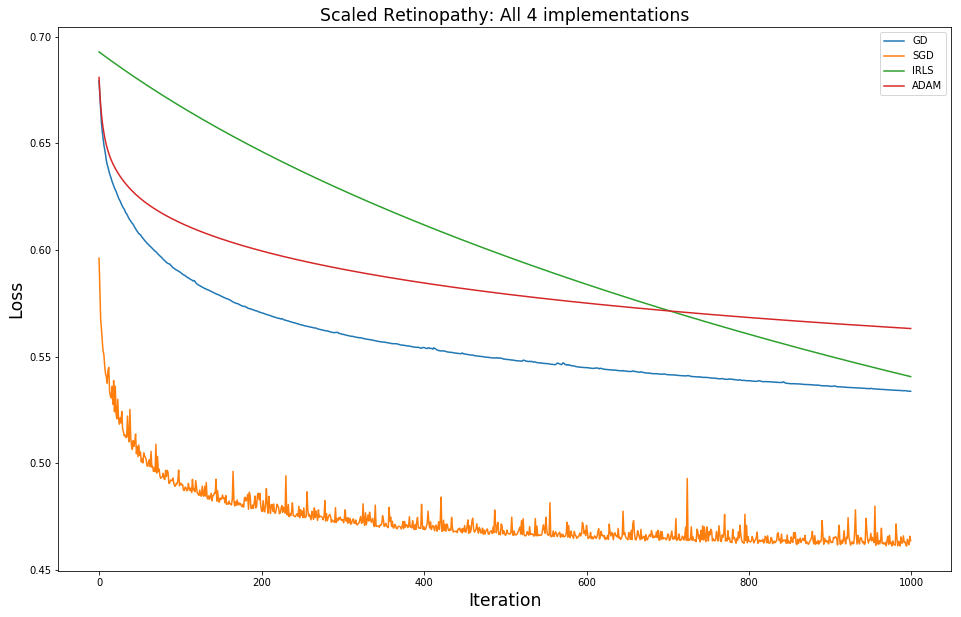

In [51]:
plt.figure(figsize=(16, 10))
losses_scaled={}
for model_name, model in lr_models_scaled.items():
    model.train(X_train_scaled, y_train_scaled)
    losses_scaled[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses_scaled[model_name])), losses_scaled[model_name], label=model_name)
plt.title('Scaled Retinopathy: All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('retinopathy_conv_03.svg')
plt.show()

In [52]:
acc, rec, prec, f_m = measures.get_measures(lr_models_scaled['ADAM'].predict(X_test_scaled), y_test_scaled)
print('Metrics of ADAM model on test subset')
print('Accuracy', round(acc, 2))
print('Recall', round(rec, 2))
print('Precision', round(prec, 2))
print('F1 score', round(f_m, 2))

Metrics of ADAM model on test subset
Accuracy 0.64
Recall 0.54
Precision 0.7
F1 score 0.61


Comparison of algorithms afficiency:

In [94]:
comp_df = pd.DataFrame(columns=['algorithm', 'scaling', 'f_score'])
for model_name in lr_models:
    acc_no_scal = measures.f_measure(lr_models[model_name].predict(X_test), y_test)
    acc_scaled = measures.f_measure(lr_models_scaled[model_name].predict(X_test_scaled), y_test_scaled)
    comp_df = pd.concat((comp_df, pd.DataFrame({'algorithm': [model_name]*2,
                                                'scaling': [False, True],
                                                'f_score': [acc_no_scal, acc_scaled]})), ignore_index=True)

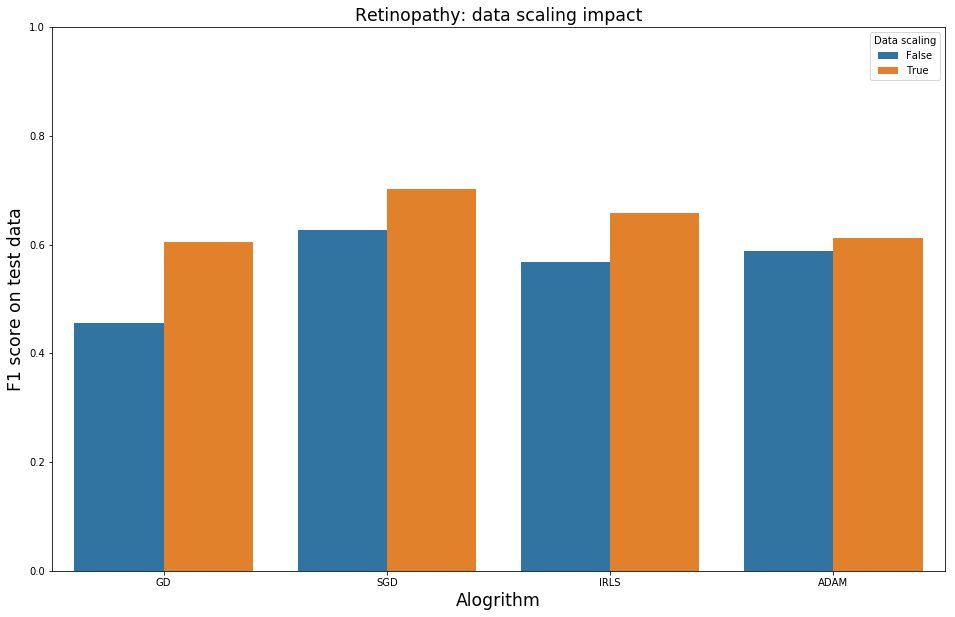

In [96]:
plt.figure(figsize=(16, 10))
sns.barplot(x='algorithm', y='f_score', data=comp_df, hue='scaling')
plt.legend(loc=1, title='Data scaling')
plt.ylim(0, 1)
plt.title('Retinopathy: data scaling impact', fontsize='xx-large')
plt.xlabel('Alogrithm', fontsize='xx-large')
plt.ylabel('F1 score on test data', fontsize='xx-large')
plt.savefig('retinopathy_scaling_impact.svg')
plt.show()

The impact of data scaling before training is significantly positive, therefore these data will be used in the following part of the notebook

#### 2. Check how the value of learning rate and other parameters affect the results.

In [61]:
tested_l_rates=np.linspace(start=0.2,stop=1e-5,num=11)
tested_algorithms={'GD': 'Gradient Descent','SGD':'Stochastic Gradient Descent','ADAM':'Adaptive Moment Estimation'}
res_test_learning_rates_total=pd.DataFrame()
for i in range(10):
    res_test_learning_rates=experiments.test_learning_rates(X_train=X_train_scaled,
                                                            y_train=y_train_scaled,
                                                            X_test=X_test_scaled,
                                                            y_test=y_test_scaled,
                                                            l_rates=tested_l_rates,
                                                            algorithms=tested_algorithms,
                                                            batch_size=0.1,
                                                            n_epochs=150)
    res_test_learning_rates_total=pd.concat([res_test_learning_rates_total,res_test_learning_rates],ignore_index=True)


In [69]:
res_test_learning_rates_total_mean = res_test_learning_rates_total.groupby(by=['method','learning_rate']).mean()

In [70]:
res_test_learning_rates_total_mean

accuracy  recall  precision  F_measure
method learning_rate                                        
ADAM   0.000010          0.569   0.516      0.612      0.560
       0.020009          0.642   0.569      0.702      0.628
       0.040008          0.632   0.536      0.701      0.607
       0.060007          0.642   0.549      0.712      0.620
       0.080006          0.628   0.536      0.695      0.605
       0.100005          0.632   0.536      0.701      0.607
       0.120004          0.625   0.529      0.692      0.600
       0.140003          0.625   0.529      0.692      0.600
       0.160002          0.625   0.529      0.692      0.600
       0.180001          0.625   0.529      0.692      0.600
       0.200000          0.625   0.529      0.692      0.600
GD     0.000010          0.594   0.556      0.634      0.592
       0.020009          0.642   0.523      0.727      0.608
       0.040008          0.646   0.523      0.734      0.611
       0.060007          0.635   0.516      0.718      0.601
       0.080006          0.639   0.523      0.721      0.606
       0.100005          0.639   0.523      0.721      0.606
       0.120004          0.639   0.523      0.721      0.606
       0.140003          0.632   0.516      0.712      0.598
       0.160002          0.632   0.510      0.716      0.595
       0.180001          0.635   0.516      0.718      0.601
       0.200000          0.632   0.503      0.720      0.592
SGD    0.000010          0.608   0.542      0.659      0.595
       0.020009          0.698   0.641      0.754      0.693
       0.040008          0.684   0.621      0.742      0.676
       0.060007          0.722   0.673      0.774      0.720
       0.080006          0.729   0.673      0.786      0.725
       0.100005          0.733   0.660      0.802      0.724
       0.120004          0.684   0.627      0.738      0.678
       0.140003          0.701   0.582      0.802      0.674
       0.160002          0.684   0.680      0.712      0.696
       0.180001          0.691   0.673      0.725      0.698
       0.200000          0.698   0.673      0.736      0.703

Top 2 values of metrices for algorithms:

In [71]:
res_test_learning_rates_total_mean.sort_values(['method', 'accuracy', 'F_measure'], ascending=[True, False, False])\
                                  .groupby('method').head(2)

accuracy  recall  precision  F_measure
method learning_rate                                        
ADAM   0.020009          0.642   0.569      0.702      0.628
       0.060007          0.642   0.549      0.712      0.620
GD     0.040008          0.646   0.523      0.734      0.611
       0.020009          0.642   0.523      0.727      0.608
SGD    0.100005          0.733   0.660      0.802      0.724
       0.080006          0.729   0.673      0.786      0.725

From the informations above (tested 10 times) we conclude that the best learning rates are:
- 0.02 or 0.06 for ADAM (its lr decreases a little with each epoch)
- 0.08 or 0.1 for SGD
- 0.02 or 0.04 for GD

However, conducted experiments did not indicate any monotonic dependencies between learning rates and scores.

Testing ADAM's betas:, along with a few learning rates on fixed number of epochs:

In [74]:
tested_betas_1=np.linspace(start=0.75,stop=.97,num=12)
tested_betas_2=np.linspace(start=0.90,stop=0.99,num=10)
tested_lr_adam=[0.002, 0.02, 0.06, 0.2]

res_test_betas=experiments.test_betas(X_train=X_train_scaled, 
                                      y_train=y_train_scaled,
                                      X_test=X_test_scaled,
                                      y_test=y_test_scaled,
                                      tested_betas1=tested_betas_1,
                                      tested_betas2=tested_betas_2,
                                      learning_rates=tested_lr_adam,
                                      n_epochs=150)

res_test_betas.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(10)

,beta1,beta2,accuracy,recall,precision,F_measure,lr
226,0.95,0.96,0.652778,0.575163,0.715447,0.637681,0.02
227,0.95,0.97,0.649306,0.575163,0.709677,0.635379,0.02
186,0.87,0.96,0.649306,0.568627,0.713115,0.632727,0.02
196,0.89,0.96,0.649306,0.568627,0.713115,0.632727,0.02
206,0.91,0.96,0.649306,0.568627,0.713115,0.632727,0.02
215,0.93,0.95,0.649306,0.568627,0.713115,0.632727,0.02
216,0.93,0.96,0.649306,0.568627,0.713115,0.632727,0.02
220,0.95,0.90,0.649306,0.555556,0.720339,0.627306,0.02
127,0.75,0.97,0.645833,0.568627,0.707317,0.630435,0.02
128,0.75,0.98,0.645833,0.568627,0.707317,0.630435,0.02


The experiments (tested n_epochs=30, 40, 50, 75 ,100) above have shown that while using different values of beta, lr=0.2 turns out to be the best value. beta1 ~ 0.95 and beta2 ~ 0.96 reach decent levels of metrics on test datasets, anyway they are still not that high as the ones of the previous SGD model.

#### 4. Compare the classification performance of logistic regression (try all 4 methods: IWLS, GD, SGD and ADAM) and 3 popular classification methods: LDA, QDA and KNN. Use the performance measures implemented in Part 2 and datasets prepared in Part 1. The performance measures should be calculated on test set. If the given algorithm does not converge, within 1000 iterations, stop the algorithm and use the solutions from the last iteration.

In [77]:
n_epochs=1000

batch_size_gd=0.1
lr_gd=0.04

lr_sgd=0.1

lr_adam=0.02
beta1_adam=0.95
beta2_adam=0.96

models = {
    'GD': LogReg(optimization='Gradient Descent',
                 learning_rate=lr_gd,
                 epochs=n_epochs,
                 batch_size=batch_size_gd),
    'SGD': LogReg(optimization='Stochastic Gradient Descent',
                  learning_rate=lr_sgd,
                  epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares',
                   epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation',
                   epochs=n_epochs,
                   learning_rate=lr_adam,
                   beta_1=beta1_adam,
                   beta_2=beta2_adam,
                   epsilon=1e-8),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'LR': LogisticRegression(max_iter=n_epochs),
    'kNN': KNeighborsClassifier()
}

In [78]:
res_final=experiments.final_comparisson(X_train=X_train_scaled,
                                        y_train=y_train_scaled,
                                        X_test=X_test_scaled,
                                        y_test=y_test_scaled,
                                        models=models)

res_final.sort_values(by=['accuracy','f_measure','recall','precision'],ascending=False)

/home/pawel/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,model,accuracy,recall,precision,f_measure
1,SGD,0.697917,0.666667,0.739130,0.701031
2,IRLS,0.694444,0.555556,0.809524,0.658915
4,LDA,0.684028,0.555556,0.787037,0.651341
6,LR,0.652778,0.555556,0.726496,0.629630
3,ADAM,0.645833,0.555556,0.714286,0.625000
0,GD,0.635417,0.542484,0.703390,0.612546
7,kNN,0.590278,0.496732,0.649573,0.562963
5,QDA,0.534722,1.000000,0.533101,0.695455


Two algorithms implemented by ourselves, SGD and IRLS are the most powerful classification models out of all checked. What is surprising is that LDA took the third position on the podium. On the other side, kNN and QDA performances are the worst, especially QDA which predictions are not much better than baseline predictions of most frequent class (positive - 53% accuracy).

#### 5. Comparing convergence analysis for the "best" parameters.

In [98]:
n_epochs=1000

batch_size_gd=0.1
lr_gd=0.04

lr_sgd=0.1

lr_adam=0.02
beta1_adam=0.95
beta2_adam=0.96

lr_models = {
     'GD': LogReg(optimization='Gradient Descent',
                 learning_rate=lr_gd,
                 epochs=n_epochs,
                 batch_size=batch_size_gd),
    'SGD': LogReg(optimization='Stochastic Gradient Descent',
                  learning_rate=lr_sgd,
                  epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares',
                   epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation',
                   epochs=n_epochs,
                   learning_rate=lr_adam,
                   beta_1=beta1_adam,
                   beta_2=beta2_adam,
                   epsilon=1e-8)
 }

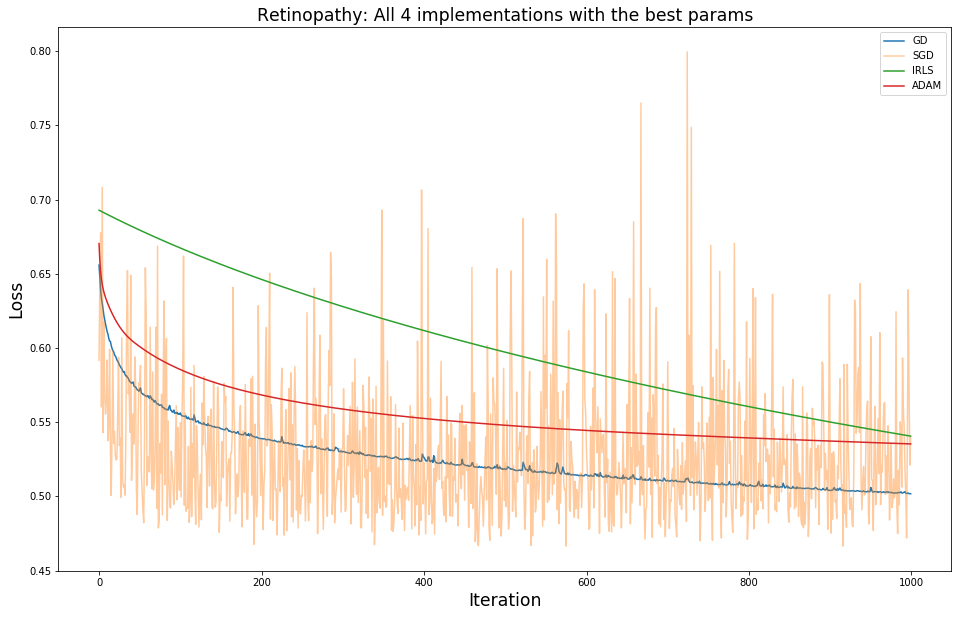

In [99]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train_scaled, y_train_scaled)
    losses[model_name]=model.get_optimizer_training_losses()
    a = 0.4 if 'SGD' == model_name else 1
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name, alpha = a)
plt.title('Retinopathy: All 4 implementations with the best params',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('retinopathy_conv_04.svg')
plt.show()

#### 6. Comparison of coefficients in different logistic regression algorithms:

In [84]:
lr_coefs = {alg: models[alg].get_optimizer_training_w().flatten() for alg in ['GD', 'SGD', 'IRLS', 'ADAM']}
lr_coefs['LR'] = np.concatenate((models['LR'].intercept_, models['LR'].coef_.flatten()))

In [85]:
pd.DataFrame(lr_coefs)

,GD,SGD,IRLS,ADAM,LR
0,0.687962,1.962163,0.193677,0.533533,0.686265
1,0.331291,0.767338,0.076295,0.797207,0.272131
2,-0.264069,-0.321206,-0.147008,-0.270710,-0.275926
3,3.990939,27.065653,5.095337,1.183091,4.741252
4,1.448220,-12.536550,-2.039792,1.148278,1.163025
5,-0.454491,-6.516952,-0.721332,0.695540,-1.031464
6,-2.013628,-5.053718,-1.787924,-0.827771,-2.305766
7,-2.037470,-1.471868,-0.302890,-0.964999,-1.751546
8,0.081602,1.100021,0.335955,-0.504197,0.233724
9,0.545333,0.683547,0.273643,0.545600,0.507832


The observation that different algorithms return different values of coefficients is quite interesting...

## Conclusions
- Balanced dataset with no missing values
- 9 out of 18 variables were drop due to high variance inflation factor
- Basically the convergence of gradient descent methods is doubtful and very slow
- However, data scaling (standardization) regularized the learning process. Fitting scaled data was done the most efficiently by SGD
- Data standardization had positive impact on values of the log-loss function and test-set predictions as well
- Different algorithms have different optimal learning rates
- betas parameters of ADAM are not very significant on the final performance of ADAM classifier
- SGD turned out to be the most efficient classifier to predict test observations, despite its learning process is still rough
- The coefficients of sklearn LogisticRegression  and Gradient Descient's were very similar.